<a href="https://colab.research.google.com/github/ndb796/PyTorch-Adversarial-Attack-Baselines-for-ImageNet-CIFAR10-MNIST/blob/main/PyTorch_FGSM_Adversarial_Attack_using_CIFAR10_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### <b>Load Required Libraries</b>

In [1]:
# load required PyTorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

f:\Environment\Python\Python3.9\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

#### <b>Image Visualization</b>

In [3]:
# load an image visualization library
import matplotlib.pyplot as plt
import PIL

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})

In [4]:
# show torch.Tensor image
def imshow(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0) # [3, H, W]
    image = transforms.ToPILImage()(image)
    # show an image whose values are between [0, 1]
    plt.imshow(image)
    plt.show()

#### <b>Load Pre-trained Classification Model</b>

In [5]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

In [6]:
model = ResNet18()
model = model.to(device)
model = torch.nn.DataParallel(model)
checkpoint = torch.load('./Model/CheckPoint/ResNet18_cifar10.pth')
model.load_state_dict(checkpoint['net'])

<All keys matched successfully>

#### <b>Load Test Dataset</b>

In [7]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

test_dataset = torchvision.datasets.CIFAR10(root='./DataSet/cifar10/', train=False, download=True,
                                            transform=transform_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=4)

Files already downloaded and verified


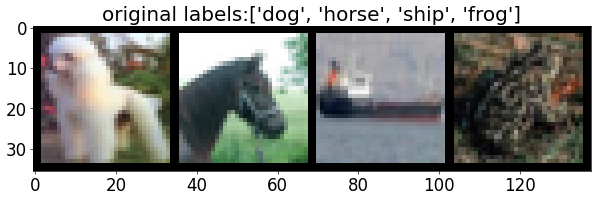

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: dog (5)
Image #2: horse (7)
Image #3: ship (8)
Image #4: frog (6)


In [9]:
import numpy as np


def imshow_batch(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of validation image
iterator = iter(test_dataloader)

# visualize a batch of validation image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow_batch(out, title='original labels:' + str([class_names[x] for x in classes[:4]]))

print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
for i, label in enumerate(classes[:4]):
    print(f'Image #{i + 1}: {class_names[label]} ({label})')

In [10]:
inputs

tensor([[[[0.2510, 0.2784, 0.3529,  ..., 0.9333, 0.8353, 0.6706],
          [0.2588, 0.2824, 0.3451,  ..., 0.8510, 0.6510, 0.5216],
          [0.2784, 0.2353, 0.4353,  ..., 0.7569, 0.5804, 0.4549],
          ...,
          [0.3333, 0.3333, 0.3490,  ..., 0.6275, 0.6627, 0.6118],
          [0.3294, 0.3176, 0.3216,  ..., 0.6039, 0.6549, 0.5765],
          [0.3490, 0.3333, 0.3333,  ..., 0.4980, 0.5412, 0.4314]],

         [[0.2078, 0.2314, 0.3020,  ..., 0.9765, 0.8824, 0.7216],
          [0.2157, 0.2314, 0.3098,  ..., 0.8902, 0.6902, 0.5569],
          [0.2275, 0.1804, 0.4118,  ..., 0.7961, 0.6235, 0.4863],
          ...,
          [0.3059, 0.2980, 0.3059,  ..., 0.6627, 0.7059, 0.6549],
          [0.3059, 0.2863, 0.2824,  ..., 0.6314, 0.6824, 0.6078],
          [0.3333, 0.3137, 0.3059,  ..., 0.5255, 0.5804, 0.4980]],

         [[0.2706, 0.2941, 0.3529,  ..., 1.0000, 0.9137, 0.7020],
          [0.2745, 0.2902, 0.3647,  ..., 0.9020, 0.6667, 0.4549],
          [0.2863, 0.2510, 0.5059,  ..., 0

#### <b>Test Phase</b>

In [26]:
import time

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                         '\npredicted labels:' + str([int(x) for x in preds[:4]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, label in enumerate(labels[:4]):
                print(f'Image #{i + 1}: {class_names[label]} ({label})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, label in enumerate(preds[:4]):
                print(f'Image #{i + 1}: {class_names[label]} ({label})')
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                         '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, label in enumerate(labels[4:8]):
                print(f'Image #{i + 1}: {class_names[label]} ({label})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, label in enumerate(preds[4:8]):
                print(f'Image #{i + 1}: {class_names[label]} ({label})')

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(test_dataset)))

#### <b>Prepare Adversarial Attack Libraries</b>

In [11]:
def get_distance(a, b):
    l0 = torch.norm((a - b).view(a.shape[0], -1), p=0, dim=1)
    l2 = torch.norm((a - b).view(a.shape[0], -1), p=2, dim=1)
    mse = (a - b).view(a.shape[0], -1).pow(2).mean(1)
    linf = torch.norm((a - b).view(a.shape[0], -1), p=float('inf'), dim=1)
    return l0, l2, mse, linf

#### <b>Adversarial Attack Example 1</b>

* <b>Attack method</b>: FGSM
* <b>Images</b>: 10,000 test images
* <b>Epsilon size</b>: 1 / 255
* FGSM is similar to 1-step PGD attack.

In [12]:
import time
from advertorch.attacks import GradientSignAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = GradientSignAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=1/255, clip_min=0.0, clip_max=1.0, targeted=False)


The dimension of an image tensor: torch.Size([3, 32, 32])
[Prediction Result Examples]


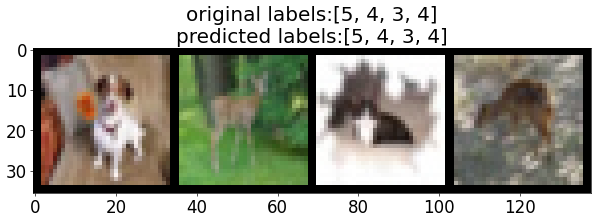

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: dog (5)
Image #1: deer (4)
Image #1: cat (3)
Image #1: deer (4)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: dog (5)
Image #1: deer (4)
Image #1: cat (3)
Image #1: deer (4)


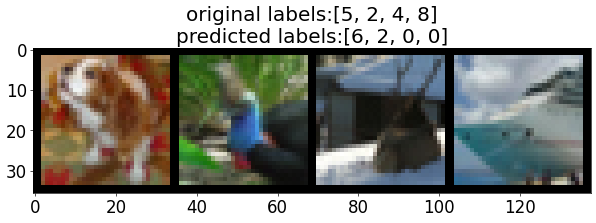

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: dog (5)
Image #1: bird (2)
Image #1: deer (4)
Image #1: ship (8)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: frog (6)
Image #1: bird (2)
Image #1: airplane (0)
Image #1: airplane (0)
[Step #0] Loss: 0.0378 Accuracy: 60.9375% Time elapsed: 7.9836s (total 64 images)
[Step #10] Loss: 0.0330 Accuracy: 65.6250% Time elapsed: 8.7552s (total 704 images)
[Step #20] Loss: 0.0331 Accuracy: 66.0714% Time elapsed: 9.5042s (total 1344 images)
[Step #30] Loss: 0.0329 Accuracy: 66.5827% Time elapsed: 10.2566s (total 1984 images)
[Step #40] Loss: 0.0328 Accuracy: 67.1875% Time elapsed: 11.0021s (total 2624 images)
[Step #50] Loss: 0.0333 Accuracy: 67.3407% Time elapsed: 11.7603s (total 3264 images)
[Step #60] Loss: 0.0340 Accuracy: 67.1106% Time elapsed: 12.5198s (total 3904 images)
[Step #70] Loss: 0.0338 Accuracy: 67.2095% Time elapsed: 13.2780s (total 4544 images)
[Step #80] Loss: 0.0336 Accuracy: 67.5540% Time elapsed: 14.0335s (total 51

In [13]:

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(test_dataset)
epoch_acc = running_corrects / len(test_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(test_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(test_dataset))
print('Average L2 distance:', running_l2 / len(test_dataset))
print('Average MSE:', running_mse / len(test_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(test_dataset))

In [20]:
test_dataloader.dataset.data[0]

array([[[158, 112,  49],
        [159, 111,  47],
        [165, 116,  51],
        ...,
        [137,  95,  36],
        [126,  91,  36],
        [116,  85,  33]],

       [[152, 112,  51],
        [151, 110,  40],
        [159, 114,  45],
        ...,
        [136,  95,  31],
        [125,  91,  32],
        [119,  88,  34]],

       [[151, 110,  47],
        [151, 109,  33],
        [158, 111,  36],
        ...,
        [139,  98,  34],
        [130,  95,  34],
        [120,  89,  33]],

       ...,

       [[ 68, 124, 177],
        [ 42, 100, 148],
        [ 31,  88, 137],
        ...,
        [ 38,  97, 146],
        [ 13,  64, 108],
        [ 40,  85, 127]],

       [[ 61, 116, 168],
        [ 49, 102, 148],
        [ 35,  85, 132],
        ...,
        [ 26,  82, 130],
        [ 29,  82, 126],
        [ 20,  64, 107]],

       [[ 54, 107, 160],
        [ 56, 105, 149],
        [ 45,  89, 132],
        ...,
        [ 24,  77, 124],
        [ 34,  84, 129],
        [ 21,  67, 110]]

In [21]:
adv_untargeted[0]

tensor([[[0.3490, 0.3490, 0.3608,  ..., 0.4078, 0.3882, 0.3961],
         [0.3647, 0.3686, 0.3647,  ..., 0.4431, 0.4000, 0.3961],
         [0.3608, 0.3608, 0.3725,  ..., 0.4510, 0.4078, 0.3922],
         ...,
         [0.4000, 0.3922, 0.3961,  ..., 0.3725, 0.3647, 0.3608],
         [0.3882, 0.4000, 0.4039,  ..., 0.3686, 0.3569, 0.3490],
         [0.3922, 0.3961, 0.3922,  ..., 0.3569, 0.3569, 0.3451]],

        [[0.4824, 0.4824, 0.4941,  ..., 0.5176, 0.4980, 0.5098],
         [0.5020, 0.5020, 0.4980,  ..., 0.5412, 0.5137, 0.5137],
         [0.4980, 0.4941, 0.5059,  ..., 0.5255, 0.5020, 0.5137],
         ...,
         [0.5255, 0.5137, 0.5176,  ..., 0.4824, 0.4824, 0.4824],
         [0.5098, 0.5216, 0.5255,  ..., 0.4784, 0.4745, 0.4706],
         [0.5059, 0.5137, 0.5137,  ..., 0.4745, 0.4745, 0.4667]],

        [[0.5804, 0.5804, 0.5922,  ..., 0.5843, 0.5686, 0.5765],
         [0.5961, 0.6000, 0.6039,  ..., 0.5961, 0.5843, 0.6000],
         [0.5961, 0.5922, 0.6000,  ..., 0.5725, 0.5804, 0.

In [22]:
labels

tensor([0, 9, 7, 3, 0, 3, 1, 6, 4, 2, 4, 2, 2, 3, 1, 7], device='cuda:0')

In [25]:
a=0
for i,(data,label) in enumerate(test_dataloader):
    if(a==1):
        print(data[i])
        print(test_dataloader.dataset.data[i]/255)
        break
    a+=1


KeyboardInterrupt: 

#### <b>Adversarial Attack Example 2</b>

* <b>Attack method</b>: FGSM
* <b>Images</b>: 10,000 test images
* <b>Epsilon size</b>: 2 / 255
* FGSM is similar to 1-step PGD attack.

The dimension of an image tensor: torch.Size([3, 32, 32])
[Prediction Result Examples]


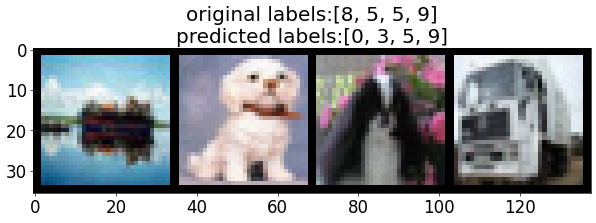

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: ship (8)
Image #1: dog (5)
Image #1: dog (5)
Image #1: truck (9)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: airplane (0)
Image #1: cat (3)
Image #1: dog (5)
Image #1: truck (9)


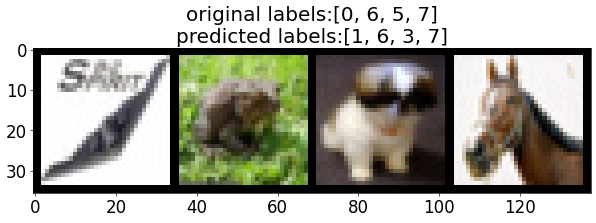

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: airplane (0)
Image #1: frog (6)
Image #1: dog (5)
Image #1: horse (7)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: automobile (1)
Image #1: frog (6)
Image #1: cat (3)
Image #1: horse (7)
[Step #0] Loss: 0.0600 Accuracy: 46.8750% Time elapsed: 0.5875s (total 64 images)
[Step #10] Loss: 0.0509 Accuracy: 55.2557% Time elapsed: 1.5523s (total 704 images)
[Step #20] Loss: 0.0498 Accuracy: 56.7708% Time elapsed: 2.5166s (total 1344 images)
[Step #30] Loss: 0.0508 Accuracy: 56.4012% Time elapsed: 3.4821s (total 1984 images)
[Step #40] Loss: 0.0509 Accuracy: 57.0122% Time elapsed: 4.4534s (total 2624 images)
[Step #50] Loss: 0.0494 Accuracy: 57.8125% Time elapsed: 5.4236s (total 3264 images)
[Step #60] Loss: 0.0496 Accuracy: 57.6588% Time elapsed: 6.3961s (total 3904 images)
[Step #70] Loss: 0.0494 Accuracy: 57.9005% Time elapsed: 7.3721s (total 4544 images)
[Step #80] Loss: 0.0496 Accuracy: 58.0826% Time elapsed: 8.3489s (total 5184 

In [ ]:
import time
from advertorch.attacks import GradientSignAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = GradientSignAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=2/255, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(test_dataset)
epoch_acc = running_corrects / len(test_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(test_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(test_dataset))
print('Average L2 distance:', running_l2 / len(test_dataset))
print('Average MSE:', running_mse / len(test_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(test_dataset))

#### <b>Adversarial Attack Example 3</b>

* <b>Attack method</b>: FGSM
* <b>Images</b>: 10,000 test images
* <b>Epsilon size</b>: 4 / 255
* FGSM is similar to 1-step PGD attack.

The dimension of an image tensor: torch.Size([3, 32, 32])
[Prediction Result Examples]


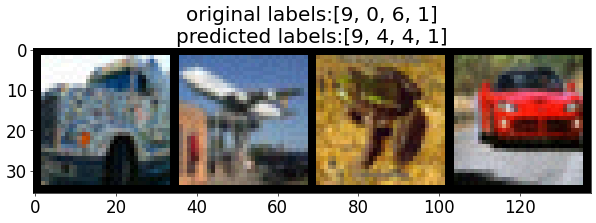

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: truck (9)
Image #1: airplane (0)
Image #1: frog (6)
Image #1: automobile (1)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: truck (9)
Image #1: deer (4)
Image #1: deer (4)
Image #1: automobile (1)


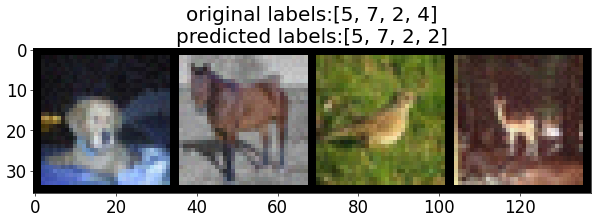

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: dog (5)
Image #1: horse (7)
Image #1: bird (2)
Image #1: deer (4)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: dog (5)
Image #1: horse (7)
Image #1: bird (2)
Image #1: bird (2)
[Step #0] Loss: 0.0508 Accuracy: 54.6875% Time elapsed: 0.5275s (total 64 images)
[Step #10] Loss: 0.0602 Accuracy: 51.4205% Time elapsed: 1.5327s (total 704 images)
[Step #20] Loss: 0.0585 Accuracy: 52.2321% Time elapsed: 2.5200s (total 1344 images)
[Step #30] Loss: 0.0582 Accuracy: 52.7218% Time elapsed: 3.5136s (total 1984 images)
[Step #40] Loss: 0.0579 Accuracy: 52.6677% Time elapsed: 4.5069s (total 2624 images)
[Step #50] Loss: 0.0578 Accuracy: 52.6654% Time elapsed: 5.5110s (total 3264 images)
[Step #60] Loss: 0.0573 Accuracy: 53.0225% Time elapsed: 6.5142s (total 3904 images)
[Step #70] Loss: 0.0577 Accuracy: 52.6628% Time elapsed: 7.5224s (total 4544 images)
[Step #80] Loss: 0.0581 Accuracy: 52.2955% Time elapsed: 8.5270s (total 5184 images)
[S

In [ ]:
import time
from advertorch.attacks import GradientSignAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = GradientSignAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=4/255, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(test_dataset)
epoch_acc = running_corrects / len(test_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(test_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(test_dataset))
print('Average L2 distance:', running_l2 / len(test_dataset))
print('Average MSE:', running_mse / len(test_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(test_dataset))

#### <b>Adversarial Attack Example 4</b>

* <b>Attack method</b>: FGSM
* <b>Images</b>: 10,000 test images
* <b>Epsilon size</b>: 8 / 255
* FGSM is similar to 1-step PGD attack.

In [39]:
import time
from advertorch.attacks import GradientSignAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = GradientSignAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=8/255, clip_min=0.0, clip_max=1.0, targeted=False)


In [42]:

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    if i ==1:
        print(inputs[0])
    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(test_dataset)
epoch_acc = running_corrects / len(test_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(test_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(test_dataset))
print('Average L2 distance:', running_l2 / len(test_dataset))
print('Average MSE:', running_mse / len(test_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(test_dataset))

#### <b>Adversarial Attack Example 5</b>

* <b>Attack method</b>: FGSM
* <b>Images</b>: 10,000 test images
* <b>Epsilon size</b>: 16 / 255
* FGSM is similar to 1-step PGD attack.

The dimension of an image tensor: torch.Size([3, 32, 32])
[Prediction Result Examples]


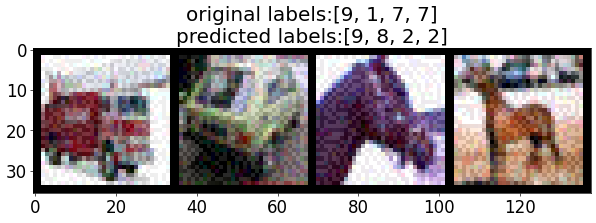

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: truck (9)
Image #1: automobile (1)
Image #1: horse (7)
Image #1: horse (7)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: truck (9)
Image #1: ship (8)
Image #1: bird (2)
Image #1: bird (2)


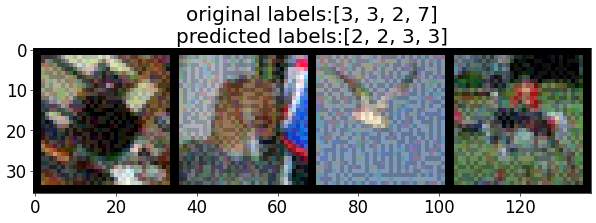

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: cat (3)
Image #1: cat (3)
Image #1: bird (2)
Image #1: horse (7)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: bird (2)
Image #1: bird (2)
Image #1: cat (3)
Image #1: cat (3)
[Step #0] Loss: 0.0647 Accuracy: 34.3750% Time elapsed: 0.5230s (total 64 images)
[Step #10] Loss: 0.0736 Accuracy: 35.5114% Time elapsed: 1.5036s (total 704 images)
[Step #20] Loss: 0.0727 Accuracy: 35.9375% Time elapsed: 2.4882s (total 1344 images)
[Step #30] Loss: 0.0744 Accuracy: 35.3831% Time elapsed: 3.4670s (total 1984 images)
[Step #40] Loss: 0.0751 Accuracy: 35.1753% Time elapsed: 4.4491s (total 2624 images)
[Step #50] Loss: 0.0758 Accuracy: 34.9877% Time elapsed: 5.4327s (total 3264 images)
[Step #60] Loss: 0.0752 Accuracy: 35.2459% Time elapsed: 6.4241s (total 3904 images)
[Step #70] Loss: 0.0749 Accuracy: 35.4533% Time elapsed: 7.4185s (total 4544 images)
[Step #80] Loss: 0.0752 Accuracy: 35.3202% Time elapsed: 8.4011s (total 5184 images)
[Step

In [ ]:
import time
from advertorch.attacks import GradientSignAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = GradientSignAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=16/255, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(test_dataset)
epoch_acc = running_corrects / len(test_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(test_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(test_dataset))
print('Average L2 distance:', running_l2 / len(test_dataset))
print('Average MSE:', running_mse / len(test_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(test_dataset))

#### <b>Adversarial Attack Example 6</b>

* <b>Attack method</b>: FGSM
* <b>Images</b>: 10,000 test images
* <b>Epsilon size</b>: 32 / 255
* FGSM is similar to 1-step PGD attack.

The dimension of an image tensor: torch.Size([3, 32, 32])
[Prediction Result Examples]


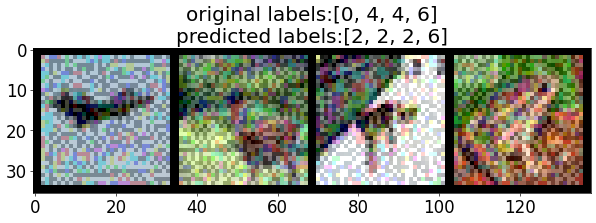

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: airplane (0)
Image #1: deer (4)
Image #1: deer (4)
Image #1: frog (6)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: bird (2)
Image #1: bird (2)
Image #1: bird (2)
Image #1: frog (6)


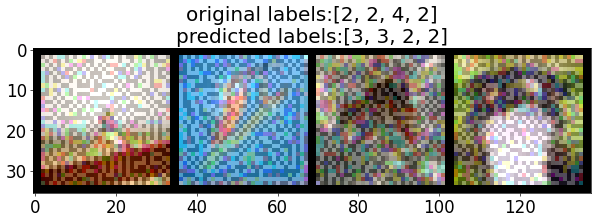

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: bird (2)
Image #1: bird (2)
Image #1: deer (4)
Image #1: bird (2)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: cat (3)
Image #1: cat (3)
Image #1: bird (2)
Image #1: bird (2)
[Step #0] Loss: 0.0981 Accuracy: 17.1875% Time elapsed: 0.5090s (total 64 images)
[Step #10] Loss: 0.1023 Accuracy: 18.0398% Time elapsed: 1.4896s (total 704 images)
[Step #20] Loss: 0.1036 Accuracy: 18.3780% Time elapsed: 2.4645s (total 1344 images)
[Step #30] Loss: 0.1039 Accuracy: 17.2883% Time elapsed: 3.4365s (total 1984 images)
[Step #40] Loss: 0.1035 Accuracy: 17.5686% Time elapsed: 4.4129s (total 2624 images)
[Step #50] Loss: 0.1040 Accuracy: 17.5551% Time elapsed: 5.3878s (total 3264 images)
[Step #60] Loss: 0.1048 Accuracy: 17.1619% Time elapsed: 6.3641s (total 3904 images)
[Step #70] Loss: 0.1056 Accuracy: 16.7694% Time elapsed: 7.3412s (total 4544 images)
[Step #80] Loss: 0.1056 Accuracy: 16.9174% Time elapsed: 8.3148s (total 5184 images)
[Ste

In [ ]:
import time
from advertorch.attacks import GradientSignAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = GradientSignAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=32/255, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(test_dataset)
epoch_acc = running_corrects / len(test_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(test_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(test_dataset))
print('Average L2 distance:', running_l2 / len(test_dataset))
print('Average MSE:', running_mse / len(test_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(test_dataset))

#### <b>Comparison with Foolbox</b>

* <b>Attack method</b>: FGSM
* <b>Images</b>: 10,000 test images
* <b>Epsilon size</b>: 32 / 255
* FGSM is similar to 1-step PGD attack.

The dimension of an image tensor: torch.Size([3, 32, 32])
[Prediction Result Examples]


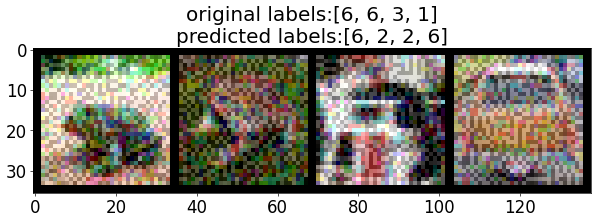

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: frog (6)
Image #1: frog (6)
Image #1: cat (3)
Image #1: automobile (1)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: frog (6)
Image #1: bird (2)
Image #1: bird (2)
Image #1: frog (6)


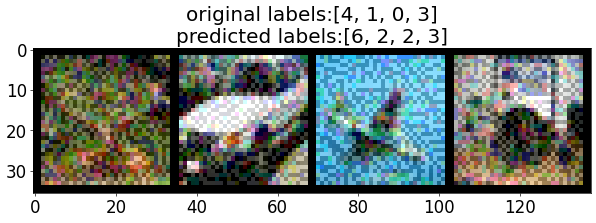

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: deer (4)
Image #1: automobile (1)
Image #1: airplane (0)
Image #1: cat (3)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: frog (6)
Image #1: bird (2)
Image #1: bird (2)
Image #1: cat (3)
[Step #0] Loss: 0.1223 Accuracy: 14.0625% Time elapsed: 0.5713s (total 64 images)
[Step #10] Loss: 0.1092 Accuracy: 16.4773% Time elapsed: 1.7057s (total 704 images)
[Step #20] Loss: 0.1075 Accuracy: 15.8482% Time elapsed: 2.8392s (total 1344 images)
[Step #30] Loss: 0.1077 Accuracy: 15.9274% Time elapsed: 3.9657s (total 1984 images)
[Step #40] Loss: 0.1058 Accuracy: 17.1494% Time elapsed: 5.0966s (total 2624 images)
[Step #50] Loss: 0.1060 Accuracy: 17.4020% Time elapsed: 6.2251s (total 3264 images)
[Step #60] Loss: 0.1058 Accuracy: 17.3668% Time elapsed: 7.3638s (total 3904 images)
[Step #70] Loss: 0.1071 Accuracy: 16.9014% Time elapsed: 8.5923s (total 4544 images)
[Step #80] Loss: 0.1068 Accuracy: 17.1103% Time elapsed: 9.7303s (total 5184 im

In [ ]:
import time
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.LinfFastGradientAttack()

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    _, adv_untargeted, _ = attack(fmodel, inputs, labels, epsilons=32/255) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[:4]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(labels[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, label in enumerate(preds[4:8]):
            print(f'Image #{i + 1}: {class_names[label]} ({label})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(test_dataset)
epoch_acc = running_corrects / len(test_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(test_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(test_dataset))
print('Average L2 distance:', running_l2 / len(test_dataset))
print('Average MSE:', running_mse / len(test_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(test_dataset))